In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here
import numpy as np
import cv2
import time
import torch
import clip
from PIL import Image
from rich import print
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

print("device", device)
model, preprocess = clip.load("ViT-B/32", device=device)

# image_dir = os.path.expanduser("~/datasets2/reconcycle/2023-02-20_hca_backs_processed")
image_dir = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped")

img_paths = []
labels = []

classes = []
for dirpath, dirnames, filenames in os.walk(image_dir):
    if len(dirnames) > 0:
        classes.extend(dirnames)

print("classes", classes)

for dirpath, dirnames, filenames in os.walk(image_dir):
    rel_dir = os.path.relpath(dirpath, image_dir)
    for filename in [f for f in filenames if f.endswith(".jpg") or f.endswith(".png")]:
        # img_path = os.path.join(rel_dir, filename) # relative
        img_path = os.path.join(dirpath, filename) # absolute
        img_paths.append(img_path)
        label_id = classes.index(rel_dir)
        labels.append(label_id)

img_paths = np.array(img_paths)
labels = np.array(labels)

print("labels", labels)

device cuda

classes
[
    'firealarm_front_04',
    'hca_back_01',
    'hca_front_01',
    'firealarm_back_05',
    'hca_back_05',
    'firealarm_back_08',
    'firealarm_back_15',
    'hca_front_11',
    'firealarm_inside_01',
    'firealarm_inside_03',
    'firealarm_inside_04',
    'firealarm_back_12',
    'hca_front_13',
    'firealarm_back_13',
    'firealarm_back_04',
    'hca_back_14',
    'hca_front_10',
    'firealarm_back_09',
    'firealarm_inside_05',
    'firealarm_back_11',
    'firealarm_front_15',
    'firealarm_front_08',
    'hca_front_06',
    'hca_back_13',
    'firealarm_front_13',
    'firealarm_inside_06',
    'firealarm_front_12',
    'hca_back_07',
    'hca_front_03',
    'hca_front_14',
    'firealarm_back_14',
    'firealarm_back_10',
    'hca_back_16',
    'hca_back_15',
    'hca_back_02',
    'hca_front_04',
    'hca_back_10',
    'hca_back_11',
    'hca_front_12',
    'firealarm_back_03',
    'firealarm_inside_02',
    'firealarm_back_06',
    'firealarm_back_02',
    'hca_back_03',
    'hca_back_04',
    'firealarm_front_14',
    'firealarm_front_03',
    'hca_back_06',
    'firealarm_front_09',
    'hca_front_09',
    'firealarm_front_01',
    'firealarm_front_10',
    'firealarm_front_02',
    'hca_front_02',
    'hca_front_08',
    'hca_back_09',
    'firealarm_front_05',
    'firealarm_front_11',
    'hca_front_05',
    'firealarm_front_07',
    'hca_back_12',
    'firealarm_back_07',
    'firealarm_front_06',
    'firealarm_back_01',
    'hca_back_08',
    'hca_front_07'
]

labels [ 0  0  0 ... 65 65 65]

In [2]:
# get first image
image = preprocess(Image.open(os.path.join(image_dir, img_paths[0]))).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9355  0.02916 0.03516]]

In [3]:
features = []
with torch.no_grad():
    for img_path in tqdm(img_paths):
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        # ? this can be sped up by using batches!
        image_features = model.encode_image(image)
        
        features.append(image_features.cpu().detach().numpy())

features = np.array(features).squeeze()

print("features.shape", features.shape)


100%|██████████| 1694/1694 [04:41<00:00,  6.01it/s]


features.shape
(1694, 512)

In [4]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

In [5]:
tsne2 = TSNE(n_components=2, random_state=0)
tsne_features = tsne2.fit_transform(features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [6]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

def do_plot(X_fit, labels, paths=None, title=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colormap = plt.cm.gist_ncar
    colors = [colormap(i) for i in np.linspace(0, 0.9,num_labels)]
    print("len(colors)", len(colors))  

    with plt.style.context(plt_style):
        fig = plt.figure(dpi=300)
        if dimension == 2:
            ax = fig.add_subplot(111)
            
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                        X_fit[labels==lab, 1],
                        color=col)
            if paths is not None:
                for x, label, path in zip(X_fit, labels, paths):
                    # print("label", label)
                    if label >= len(colors):
                        print("weird bug:", label)
                    color = colors[label]
                    ab = AnnotationBbox(getImage(path, zoom=0.1), (x[0], x[1]), frameon=True, bboxprops=dict(edgecolor=color,boxstyle="square,pad=0", lw=3))
                    ax.add_artist(ab)
            
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

len(colors) 61

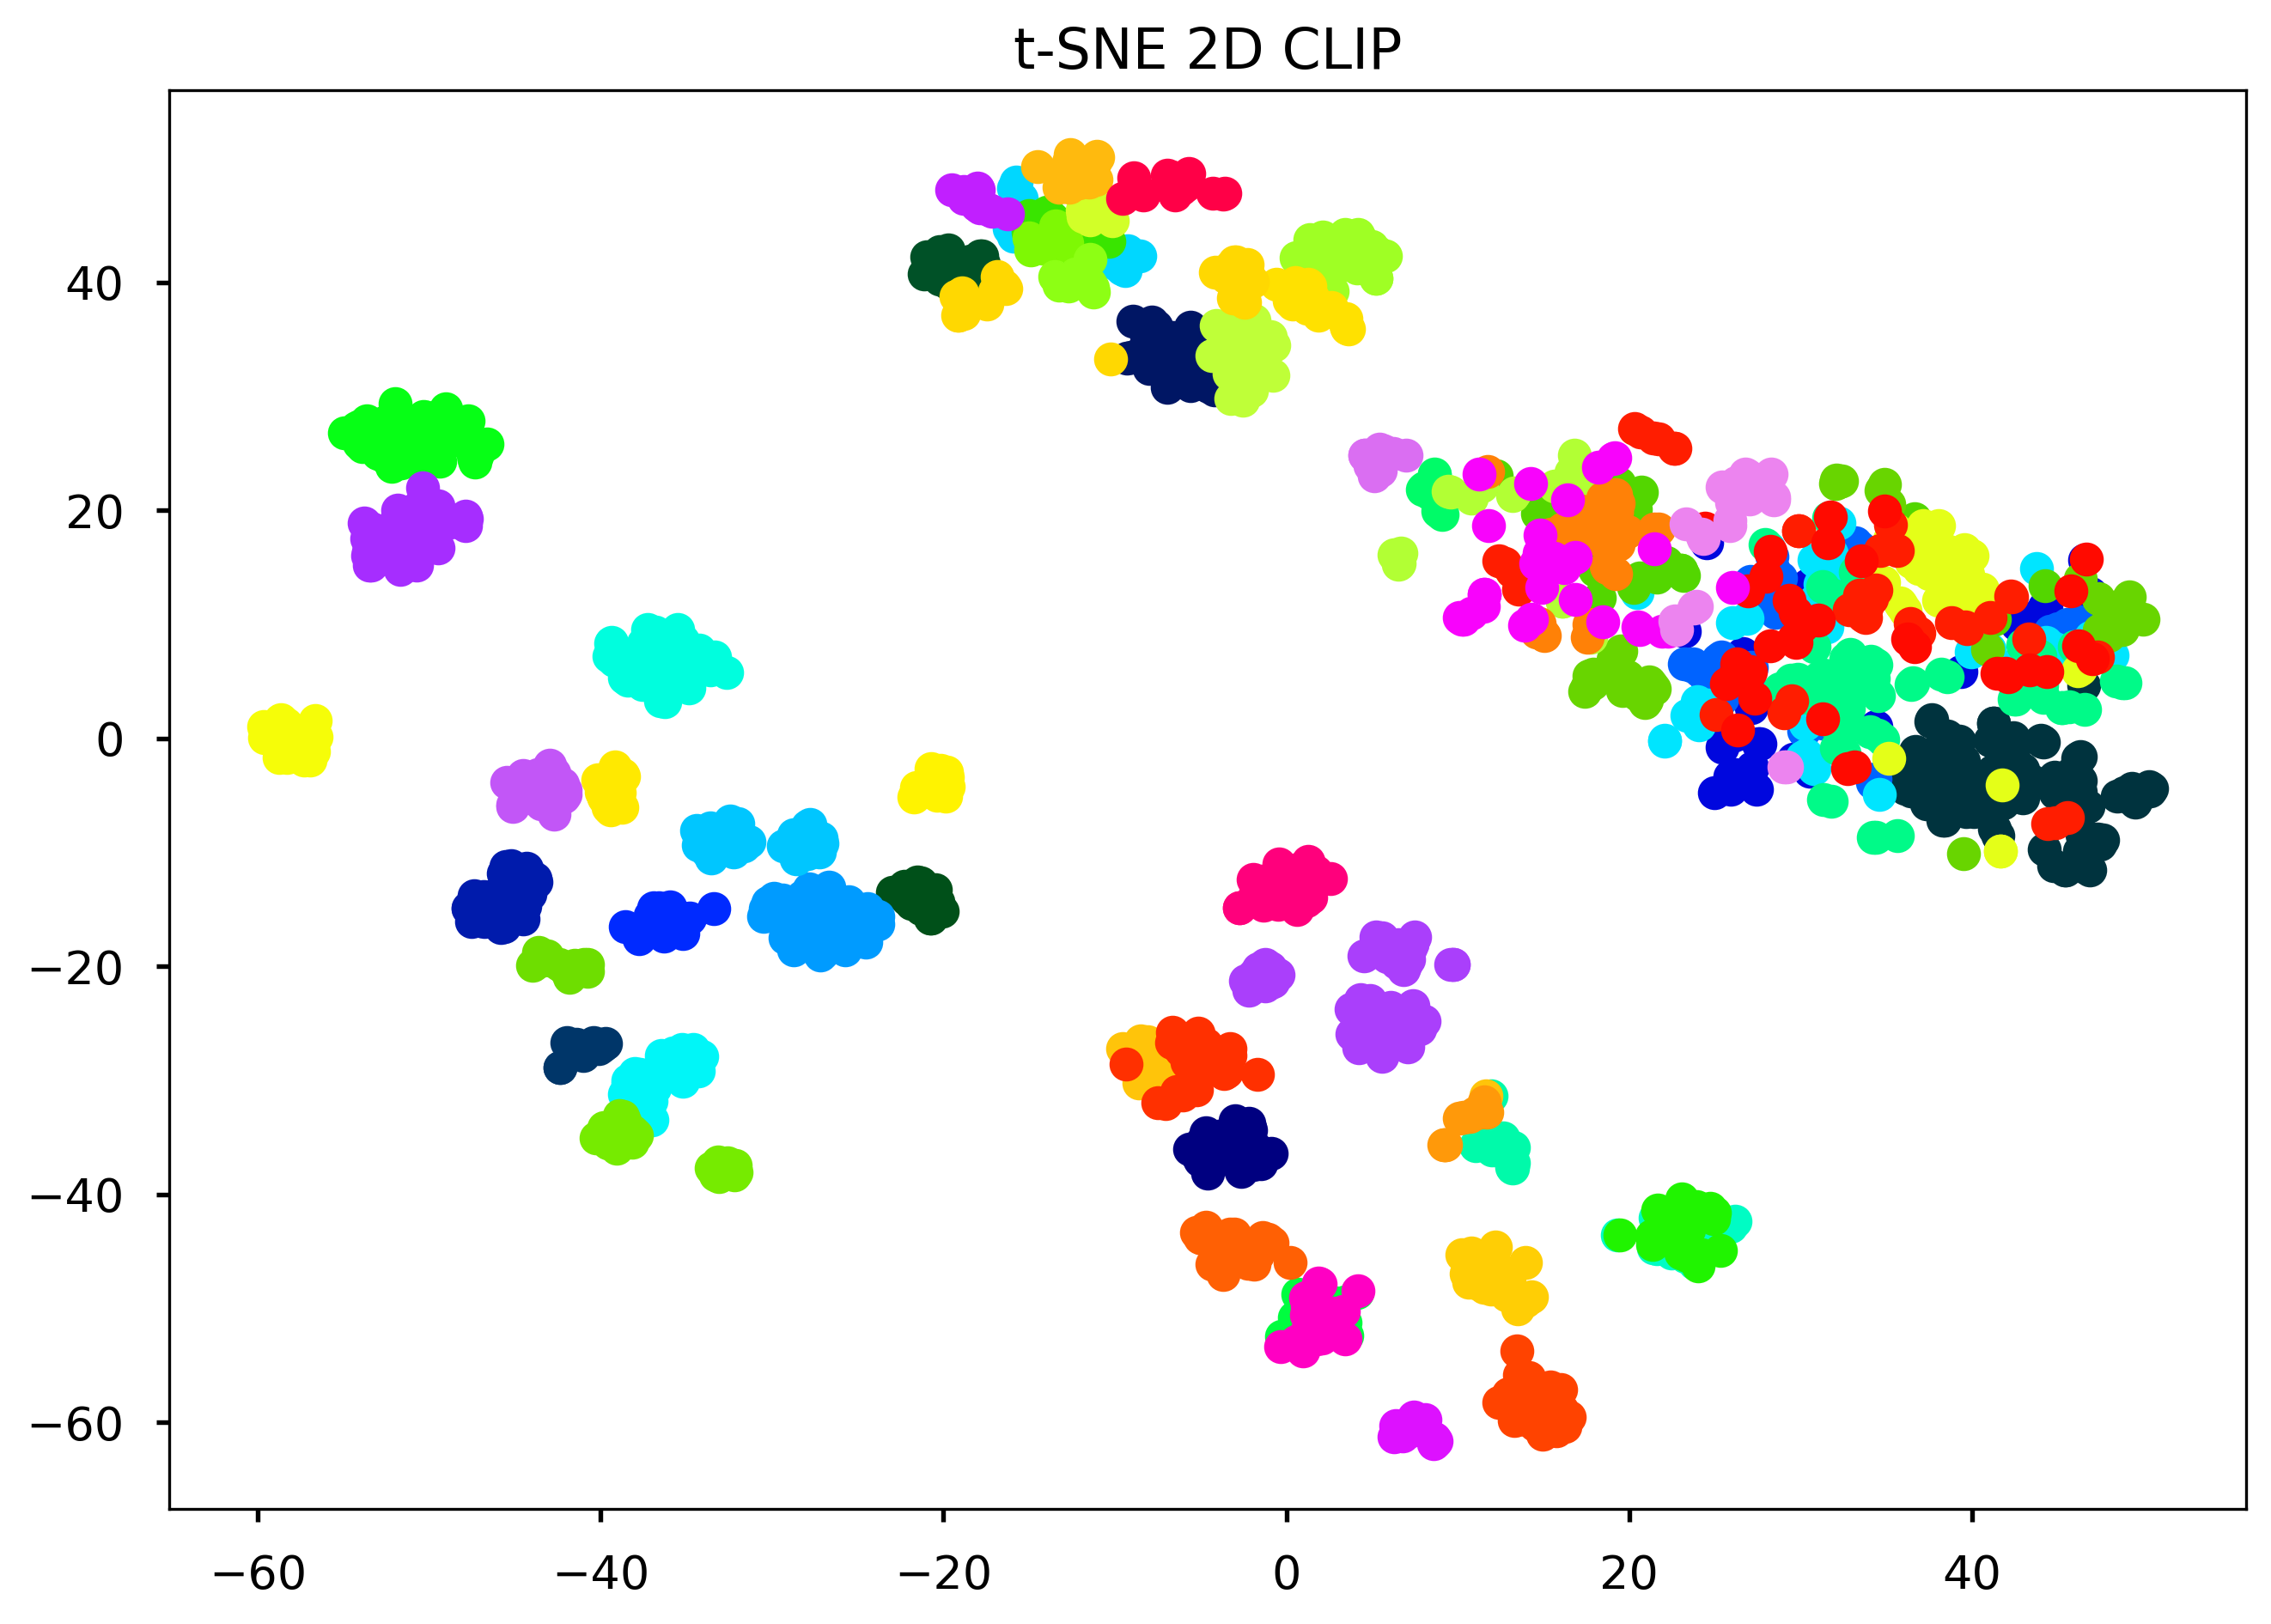

len(colors) 61

IndexError: list index out of range

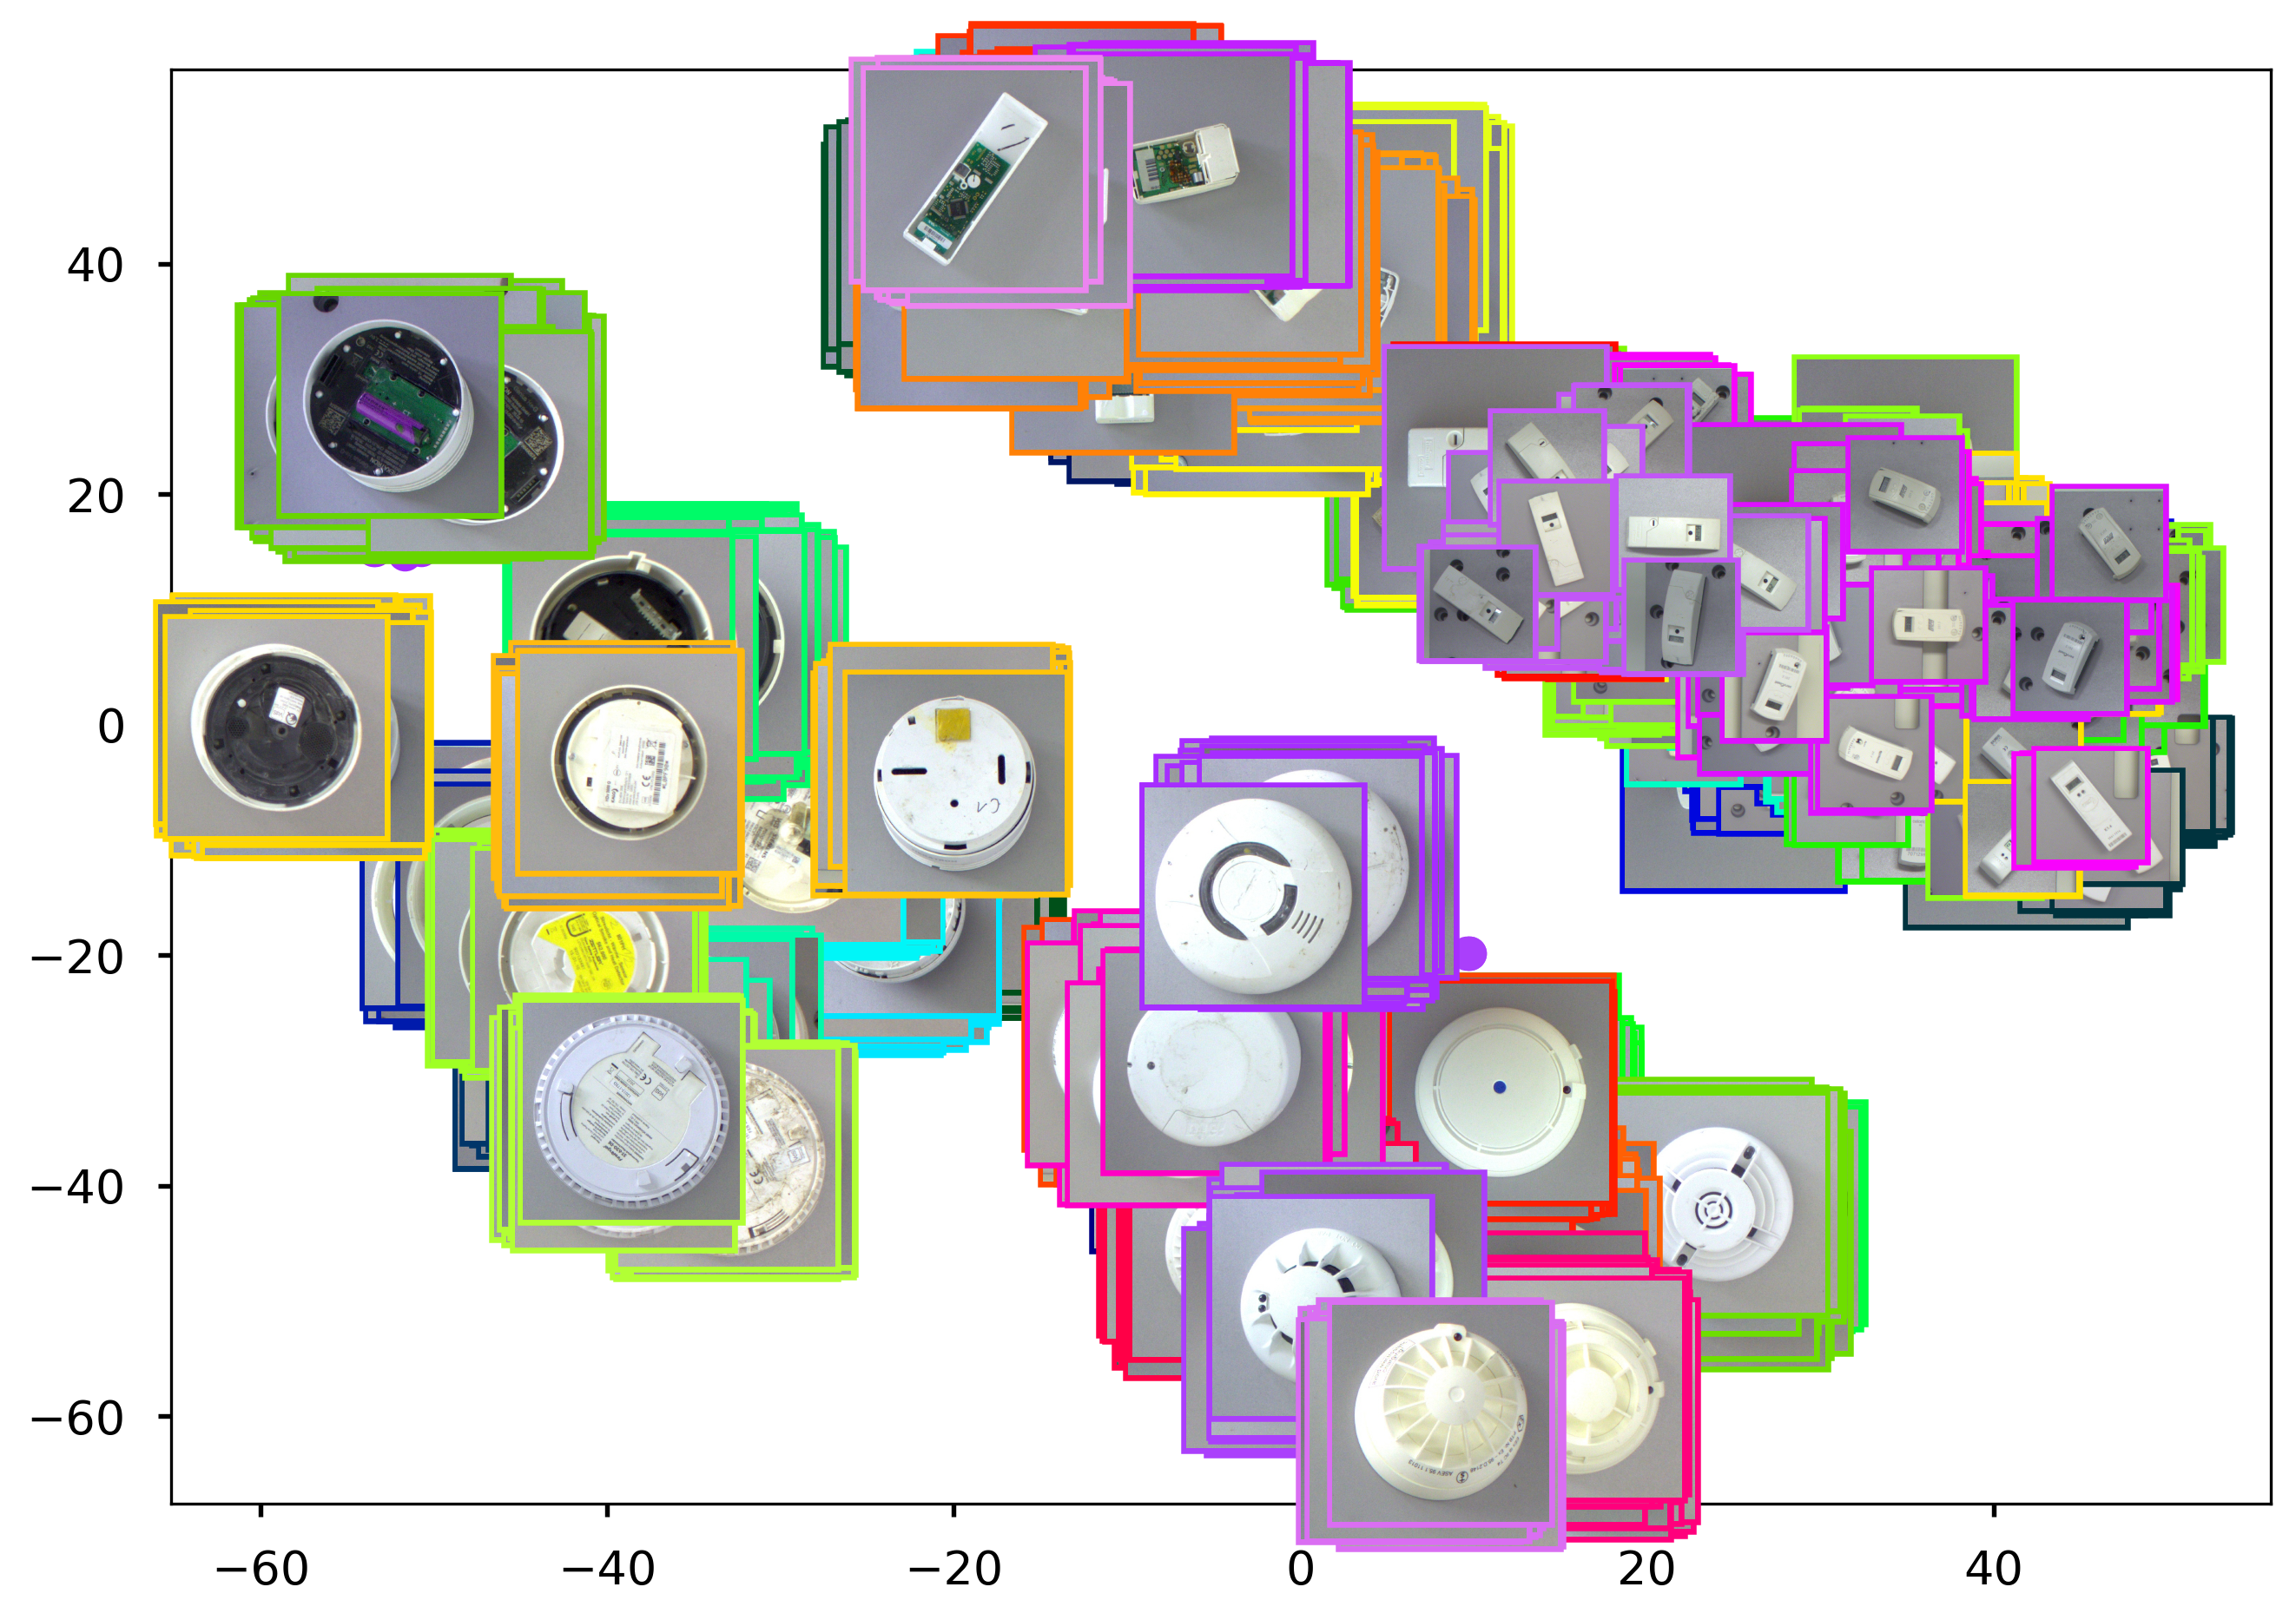

In [7]:
do_plot(tsne_features, labels, title="t-SNE 2D CLIP")
do_plot(tsne_features, labels, img_paths, title="t-SNE 2D CLIP")